# Детекция сигарет на изображениях

## Подключение `ultralytics`

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Устанавливаем ultralytics (он предустановлен в google colab, но на всякий случай проверяем)
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.5/627.5 kB 23.9 MB/s eta 0:00:00


## Обзор данных (EDA)

- Все фоторафии имеют размер 640*640 (можно выбрать и другой, нужна кратность 32).
- К каждой фотографии есть аннотация из координат угла bbox и длины и ширины его стенок.

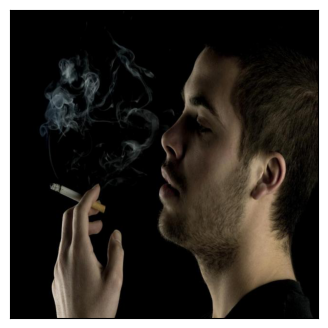

In [ ]:
'''Пример исходного изображения '''
from matplotlib import pyplot as plt


plt.figure(figsize=(4, 4))

plt.plot(131)
img_path = r'/content/drive/MyDrive/Cigarette ML/train/images/-_jpg.rf.56682d1929250f5f9ac2409c8fc92ae2.jpg'
img = plt.imread(img_path)
plt.xticks([])
plt.yticks([])
plt.imshow(img)

In [ ]:
'''Пример аннотации изображения'''

# аннотация содержит метку класса и координаты bbox
annotation_path = r'/content/drive/MyDrive/Cigarette ML/train/labels/-_jpg.rf.56682d1929250f5f9ac2409c8fc92ae2.txt'
with open(annotation_path, 'r') as annotation:
    print(annotation.read())

0 0.21796875 0.60625 0.2046875 0.13046875


## Выбор модели

Будет использоваться модели `YOLOv8n`.

[Основные характеристики моделей](https://docs.ultralytics.com/models/yolov8/#supported-modes)

## Обучение моделей

In [4]:
'''Обучение модели YOLOvn'''

from ultralytics import YOLO

# Путь к модели
model_path = r'/content/drive/MyDrive/Cigarette ML/models/yolov8n.pt'
# Загрузка модели
model = YOLO(model_path)

In [16]:
# Обучение модели
model.train(data='/content/drive/MyDrive/Cigarette ML/data.yaml', epochs=150, imgsz=640)

Ultralytics YOLOv8.0.132 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Cigarette ML/models/yolov8n.pt, data=/content/drive/MyDrive/Cigarette ML/data.yaml, epochs=150, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, form

## Сохранения предсказаний

In [5]:
import cv2
import numpy as np
import torchvision.transforms as T

from PIL import Image
from matplotlib import pyplot as plt

In [6]:
best_model_path = r'/content/drive/MyDrive/Cigarette ML/models/bestYOLOv8n.pt'
model = YOLO(best_model_path)

In [38]:
test_img_path = '/content/drive/MyDrive/Cigarette ML/test/images/00027_jpg.rf.00d4ab955db606a74a55550846b6663e.jpg'

In [39]:
res = model(test_img_path)
res_plotted = res[0].plot()


image 1/1 /content/drive/MyDrive/Cigarette ML/test/images/00027_jpg.rf.00d4ab955db606a74a55550846b6663e.jpg: 640x640 2 Cigarettes, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


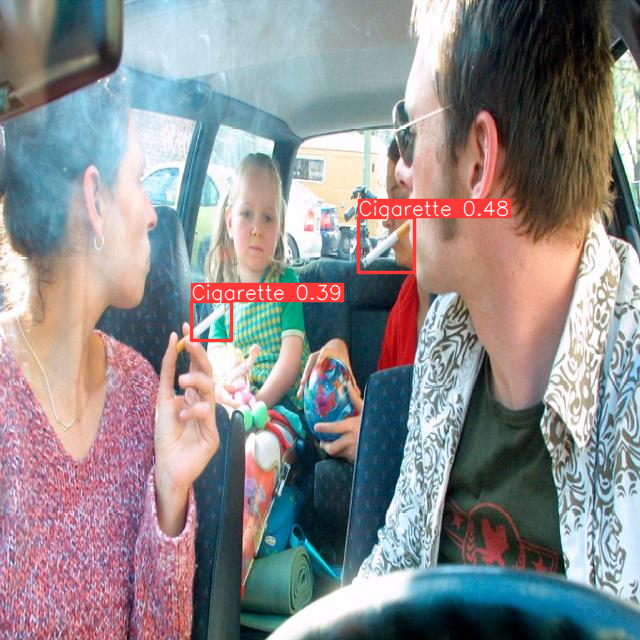

In [40]:
imageRGB = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
img = Image.fromarray(imageRGB)
img.save('test_img.jpg')
img

## Вывод

Модель может выделять искомые объекты, но с небольшой увернностью. Для повышения качества можно использовать:
- увеличить объем тренировочных данных
- провести более тонкую настройку параметров модели (например, добавить sheduler)
- аугмментировать данные
- использовать предобученную модель

# Детекция сигарет на видео видео

In [41]:
video_path = r'/content/drive/MyDrive/Cigarette ML/video_for_detection_cigarette.mp4'

In [42]:
stream_video = model.predict(video_path, stream=True)

In [57]:
def video_pose(filename, out_filename):
    # Берём видео и считываем основные параметры
    cap = cv2.VideoCapture(filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    # Создаем класс для записи
    out = cv2.VideoWriter(out_filename, fourcc, fps, (width, height))
    #  Обрабатываем кадры
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame = model(frame)
            frame = frame[0].plot()
            out.write(frame)
        else:
            break
    cap.release()
    out.release()

In [58]:
video_pose(video_path, 'ready.mp4')


0: 384x640 1 Cigarette, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cigarette, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cigarette, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cigarette, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cigarette, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cigarette, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cigarette, 6.2ms
Speed: 2.3ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cigarette, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape

## Вывод

Модель детектирует объекты, но есть недостаток точности. Иногда появляются ложные предсказания на объекты схожей формы. Стоит дообучить модель.